In [55]:
import json
import os
from json import JSONDecodeError
import sys
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
os.listdir()

['DR_FSP_DR_PFSP',
 'DR_SP_DR_FSP',
 'DR_SP_DR_PFSP',
 'parse_results',
 'rr_parsing.py',
 'rr_viz.ipynb']

In [57]:
def plot_returns(values: pd.Series, agent_name: str):
    df = pd.DataFrame(values)
    df.columns = ["values"]
    df["avg"] = df["values"].apply(lambda x: np.array(x).mean())
    df["std"] = df["values"].apply(lambda x: np.array(x).std())

    df["lower"] = df["avg"] - df["std"]
    df["upper"] = df["avg"] + df["std"]

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=np.array([df.index, df.index[::-1]]).flatten(),
            y=np.array([df["upper"], df["lower"][::-1]]).flatten(),
            fill="toself",
            fillcolor="rgba(0, 0, 255, 0.2)",
            line=dict(color="rgba(255, 255, 255, 0)"),
            name="Error Band",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df["avg"],
            mode="lines",
            line=dict(color="blue"),
            name="Average",
        )
    )

    fig.update_layout(
        title=agent_name,
        xaxis_title="Checkpoints",
        yaxis_title="Returns",
        showlegend=True,
    )
    fig.show()

In [58]:
def plot_logs(agent_1: str, agent_2: str):
    with open(f"parse_results/{agent_1}_{agent_2}_returns.json", "r") as f:
        logs = json.load(f)
    plot_returns(pd.Series(logs[agent_1]), agent_1)
    plot_returns(pd.Series(logs[agent_2]), agent_2)

In [59]:
plot_logs("DR_SP", "DR_FSP")

In [60]:
plot_logs("DR_SP", "DR_PFSP")

In [61]:
plot_logs("DR_FSP", "DR_PFSP")

In [62]:
def plot_logs(agent_1: str, agent_2: str):
    with open(f"parse_results/{agent_1}_{agent_2}_returns.json", "r") as f:
        logs = json.load(f)
    plot_returns(pd.Series(logs[agent_1]), agent_1)
    plot_returns(pd.Series(logs[agent_2]), agent_2)

In [63]:
df = {}
logs = [file for file in os.listdir("parse_results") if ".json" in file]
for log in logs:
    print(log) 
    with open(f"parse_results/{log}", "r") as f:
        returns = json.load(f)

    df[log] = returns

DR_FSP_DR_PFSP_returns.json
DR_SP_DR_FSP_returns.json
DR_SP_DR_PFSP_returns.json


In [64]:
for log in list(df.keys()):
    for agent in df[log].keys():
        print(agent)
        print(len(list(df[log][agent].keys())))

DR_FSP
109
DR_PFSP
109
DR_SP
40
DR_FSP
40
DR_SP
40
DR_PFSP
40


In [65]:
df = {}
logs = [file for file in os.listdir("parse_results") if ".json" in file]
for log in logs:
    print(log) 
    with open(f"parse_results/{log}", "r") as f:
        returns = json.load(f)

        agent_1, agent_2 = list(returns.keys())
        if agent_1 not in df.keys():
            df[agent_1] = returns[agent_1]
        if agent_2 not in df.keys():
            df[agent_2] = returns[agent_2]
        else:
            for checkpoint in list(returns[agent_1].keys()):
                df[agent_1][checkpoint].extend(returns[agent_1][checkpoint])
            for checkpoint in list(returns[agent_2].keys()):
                df[agent_2][checkpoint].extend(returns[agent_2][checkpoint])

df = pd.DataFrame(df)

df.index = np.array(df.index).astype(int)
df = df.sort_index()
# df = df.head(40)

agents = df.columns
fig = go.Figure()

for agent in agents:
    df[f"{agent}_avg"] = df[agent].apply(lambda x: np.array(x).mean())
    df[f"{agent}_std"] = df[agent].apply(lambda x: np.array(x).std())

    df[f"{agent}_lower"] = df[f"{agent}_avg"] - df[f"{agent}_std"]
    df[f"{agent}_upper"] = df[f"{agent}_avg"] + df[f"{agent}_std"]


    # fig.add_trace(
    #     go.Scatter(
    #         x=np.array([df.index, df.index[::-1]]).flatten(),
    #         y=np.array([df[f"{agent}_upper"], df[f"{agent}_lower"][::-1]]).flatten(),
    #         fill="toself",
    #         fillcolor="rgba(0, 0, 255, 0.2)",
    #         line=dict(color="rgba(255, 255, 255, 0)"),
    #         name="Error Band",
    #     )
    # )
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[f"{agent}_avg"],
            mode="lines",
            name=agent,
        )
    )

fig.update_layout(
    title="RR returns",
    xaxis_title="Checkpoints",
    yaxis_title="Returns",
    showlegend=True,
)
fig.show()

DR_FSP_DR_PFSP_returns.json
DR_SP_DR_FSP_returns.json
DR_SP_DR_PFSP_returns.json


In [66]:
df["DR_SP"].dropna().shape

(40,)

In [67]:
directory = "DR_FSP_DR_PFSP"
agent_path = directory.split("/")[0].split("_")
agent_1 = "_".join(agent_path[:2])
agent_2 = "_".join(agent_path[2:])

ckp_path = directory.split(".")[0].split("/")[-1].split("_")
ckp_1 = ckp_path[0]
ckp_2 = ckp_path[2]

agent_1, agent_2, ckp_1, ckp_2

('DR_FSP', 'DR_PFSP', 'DR', 'DR')

In [68]:
def correct_json_format(path: str, overwrite: bool = False):
    """Converts a round-robin output to correct json format."""
    try:
        with open(path) as f:
            logs = json.load(f)
        return logs

    except JSONDecodeError:
        agent_path = path.split("/")[0].split("_")
        agent_1 = "_".join(agent_path[:2])
        agent_2 = "_".join(agent_path[2:])

        ckp_path = path.split(".")[0].split("/")[-1].split("_")
        ckp_1 = ckp_path[0]
        ckp_2 = ckp_path[2]

        print(agent_1, agent_2, ckp_1, ckp_2)

        with open(path, "r") as file:
            lines = file.readlines()
        data = [eval(line.strip()) for line in lines]
        assert len(data) == 2, "More than two entries"
        new_data = {
            agent_1: {ckp_1: data[0]},
            agent_2: {ckp_2: data[1]},
        }

        if overwrite:
            with open(path, "w") as output_file:
                json.dump(new_data, output_file, indent=4)

        return new_data


def merge_logs(dir: str, log_dir: str):
    """
    Parses the matchup folder and returns a
    dictionary of returns for each agent/checkpoint pair
    """
    agent_path = dir.split("_")
    agent_1 = "_".join(agent_path[:2])
    agent_2 = "_".join(agent_path[2:])

    merged_logs = {agent_1: {}, agent_2: {}}

    for file in tqdm(os.listdir(dir)):
        path = os.path.join(dir, file).replace(chr(92), "/")
        path = path.replace("\\", "/")
        try:
            with open(os.path.join(dir, file)) as f:
                logs = json.load(f)
        except JSONDecodeError:
            correct_json_format(path, overwrite=True)
            with open(os.path.join(dir, file)) as f:
                logs = json.load(f)
        for agent in [agent_1, agent_2]:
            for checkpoint, returns in logs[agent].items():
                if checkpoint not in merged_logs[agent].keys():
                    merged_logs[agent][int(checkpoint)] = []
                merged_logs[agent][int(checkpoint)].extend([x for x in returns])

    with open(
        os.path.join(log_dir, f"{agent_1}_{agent_2}_returns.json"),
        "w",
    ) as output_file:
        json.dump(merged_logs, output_file, indent=4)

    return merged_logs

In [72]:
with open("parse_results/DR_FSP_DR_PFSP_returns.json") as f:
    data = json.load(f)

In [114]:
def plot_results(data: dict):

    LABELSIZE = 36
    TICKLABELSIZE = 24

    fig, ax = plt.subplots(figsize=(7 * 2, 3.4 * 2))
    color_palette = "colorblind"
    color_palette = sns.color_palette("deep", n_colors=len(data.keys()))
    colors = dict(zip(data.keys(), color_palette))

    for alg in data.keys():
        df = pd.DataFrame(data[alg])
        df.columns = [int(col) for col in df.columns]
        df = df.T.sort_index()
        avg = df.mean(axis=1)
        std = df.std(axis=1)
        plt.plot(
            df.index,
            avg,
            color=colors[alg],
            marker="o",
            linewidth=2,
            label=alg,
        )
        plt.fill_between(
            df.index,
            y1=avg + std,
            y2=avg - std,
            color=colors[alg],
            alpha=0.2,
        )

    plt.legend(
        loc="lower center",
        ncol=len(data.keys()),
        bbox_to_anchor=(0.5, 1.0),
        # bbox_transform=fig_sample_efficiency.transFigure,
        fontsize=30,
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)

    ax.tick_params(length=0.1, width=0.1, labelsize=TICKLABELSIZE)
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlabel("Steps", fontsize=LABELSIZE)
    ax.set_ylabel("Mean Episodic Return", fontsize=LABELSIZE)
    fig.tight_layout()
    ax.grid(True, alpha=0.2)

    fig.show()

    fig.savefig(f"_mean.png", bbox_inches="tight")

In [119]:
def sort_and_trim_dicts(data):
    min_length = min(len(sub_dict) for sub_dict in data.values())

    def sort_and_trim(sub_dict, N):
        sorted_keys = sorted(sub_dict.keys(), key=lambda x: int(x))[:N]
        return {k: sub_dict[k] for k in sorted_keys}

    trimmed_data = {
        key: sort_and_trim(sub_dict, min_length) for key, sub_dict in data.items()
    }

    return trimmed_data

DR_FSP_DR_PFSP_returns.json
DR_SP_DR_FSP_returns.json
DR_SP_DR_PFSP_returns.json


C:\Users\ryanp\AppData\Local\Temp\ipykernel_145772\114467854.py:53: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



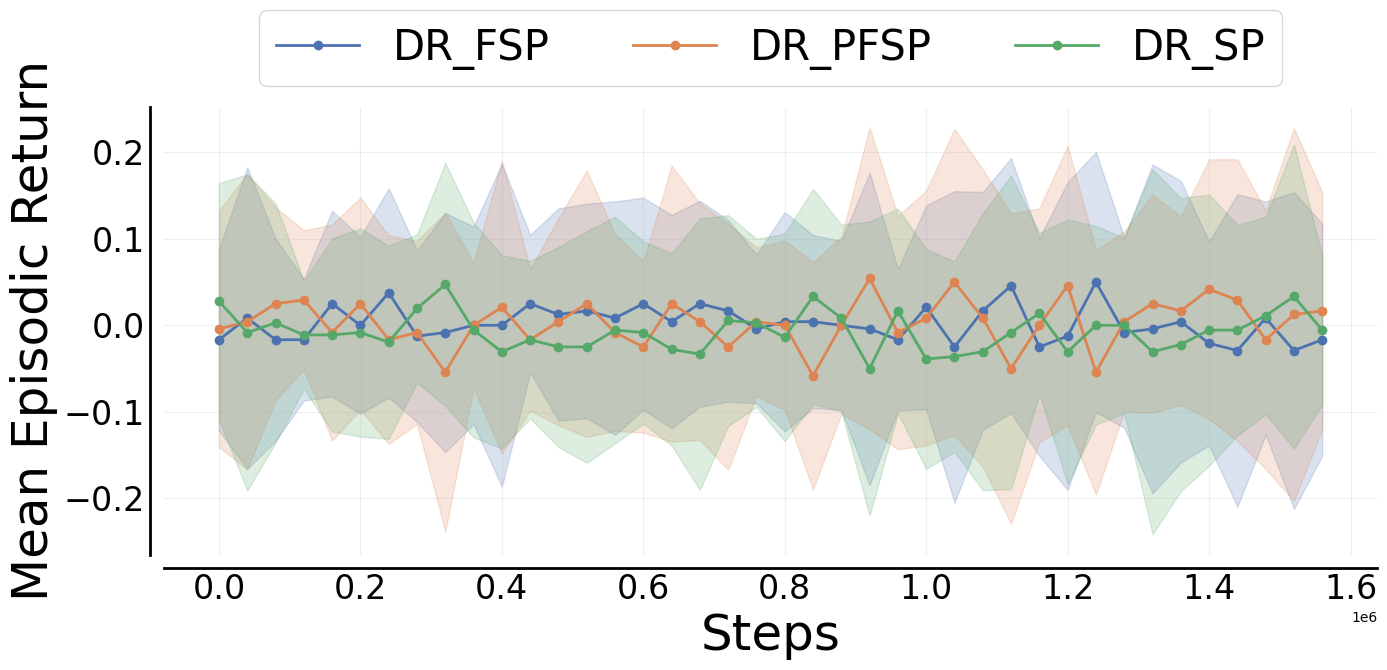

In [132]:
df = {}
logs = [file for file in os.listdir("parse_results") if ".json" in file]
for log in logs:
    print(log)
    with open(f"parse_results/{log}", "r") as f:
        returns = json.load(f)

        agent_1, agent_2 = list(returns.keys())
        if agent_1 not in df.keys():
            df[agent_1] = returns[agent_1]
        if agent_2 not in df.keys():
            df[agent_2] = returns[agent_2]
        else:
            for checkpoint in list(returns[agent_1].keys()):
                df[agent_1][checkpoint].extend(returns[agent_1][checkpoint])
            for checkpoint in list(returns[agent_2].keys()):
                df[agent_2][checkpoint].extend(returns[agent_2][checkpoint])

fig = plot_results(sort_and_trim_dicts(df))

In [131]:
def check_dir_name(dir: str):
    split = dir.split("_")
    valid_names = ["DR", "PLR", "SP", "FSP", "PFSP"]
    return all([x in valid_names for x in split])


valid_dirs = [dir for dir in os.listdir() if check_dir_name(dir)]
valid_dirs

['DR_FSP_DR_PFSP', 'DR_SP_DR_FSP', 'DR_SP_DR_PFSP']